# Example YOLOv2 detector

This notebook shows the complete pipeline to create and train a new model for `faces` detection (trained on the `Wider Faces` dataset).

## Imports + model initialization

The 1st step is to create the model. Note that the `nb_class` attribute in the configuration corresponds to the number of possible class to detect. It must be greater than 1 (if not, will automatically be set to 2). 

If you put it higher than the real number of labels, it allows you to add new object later which can be interesting ! (pay attention that if you try it, you will have to train on both (new and old classes) otherwise your model will become poor on old classes). 

In [1]:
import pandas as pd
import tensorflow as tf

from utils import plot, plot_multiple, set_display_options, limit_gpu_memory
from datasets import get_dataset, prepare_dataset, test_dataset_time, train_test_split
from models.detection import YOLO
from models import get_pretrained

set_display_options()
#limit_gpu_memory()

input_size = 416
model_name = 'yolo_faces'
print("Tensorflow version : {}".format(tf.__version__))

Tensorflow version : 2.10.0


In [3]:
config = {
    'input_size' : input_size,
    'backend'    : 'full_yolo',
    'nb_class'   : 5,
    'max_box_per_image' : 100,
    'labels'     : ['face'],
}
model = YOLO(nom = model_name, ** config)

print(model)

Loading weights from pretrained_models/yolo_backend/full_yolo_backend.h5
Initializing model with kwargs : {'model': {'architecture_name': 'yolo', 'feature_extractor': <keras.engine.functional.Functional object at 0x00000194B267BEB0>, 'input_shape': (416, 416, 3), 'nb_class': 5, 'nb_box': 5, 'flatten': True, 'randomize': True}}
Initializing submodel : `model` !
Submodel model saved in pretrained_models\yolo_faces\saving\model.json !
Model yolo_faces initialized successfully !

========== yolo_faces ==========
Sub model model
- Inputs 	: (None, 416, 416, 3)
- Outputs 	: (None, 13, 13, 5, 10)
- Number of layers 	: 76
- Number of parameters 	: 50.599 Millions
- Model not compiled

Already trained on 0 epochs (0 steps)

- Image size : (416, 416, 3)
- Normalization style : None
- Labels (n = 5) : ['face', '', '', '', '']
- Feature extractor : full_yolo



## Model instanciation + dataset loading

Once the model has been created, you can instanciate it simply by its name without putting all configuration again (see [this project](https://github.com/yui-mhcp/base_dl_project) for more information) !

Optimizers and config are tuned for a good training on `Wider Faces` but you can easily change their value. It seems that `SGD` is better than `adam` for this model because it sometimes leads to `NaN loss` (I don't know why but it seems to not appear with `SGD`).

Next you have to load the dataset (which must be downloaded on your laptop). Note that the `drop(index = 79)` is for the `kangaroo` dataset because this specific image seems to not be correctly formatted for `tensorflow` image decoding (why ?). 

In [2]:
model = get_pretrained(model_name)

model.compile(
    optimizer = 'sgd',
    optimizer_config = {
        'lr' : {'name' : 'WarmupScheduler', 'maxval' : 5e-3,'minval' : 1e-4, 'factor' : 1024, 'warmup_steps' : 4096}
    },
    loss_config = {'warmup_epochs' : 3}
)

print(model)

Model restoration...
Initializing submodel : `model` !
Optimizer 'model_optimizer' initilized successfully !
Successfully restored model from pretrained_models/yolo_faces/saving/model.json !
[WARNING] Some layers have not bene restored from the checkpoint ! Run `model.load_checkpoint().assert_consumed()` to check if it is a critical error or not
Model yolo_faces initialized successfully !
Model model is already compiled !

========== yolo_faces ==========
Sub model model
- Inputs 	: (None, 416, 416, 3)
- Outputs 	: (None, 13, 13, 5, 10)
- Number of layers 	: 76
- Number of parameters 	: 50.599 Millions
- Optimizer 	: {'name': 'SGD', 'learning_rate': 9.999999747378752e-05, 'decay': 0.0, 'momentum': 0.0, 'nesterov': False}
- Loss 	 : {'reduction': 'none', 'name': None, 'anchors': array([0.57273 , 0.677385, 1.87446 , 2.06253 , 3.33843 , 5.47434 ,
       7.88282 , 3.52778 , 9.77052 , 9.16828 ], dtype=float32), 'object_scale': 5.0, 'no_object_scale': 1.0, 'coord_scale': 1.0, 'class_scale': 

In [3]:
# `rectangular_boxes` is for boxes padding (required for batching)
dataset_name = 'wider'
dataset = get_dataset(
    dataset_name, max_box_per_image = model.max_box_per_image, rectangular_boxes = True
)

if isinstance(dataset, dict):
    train, valid = dataset['train'], dataset['valid']
else:
    train, valid = train_test_split(dataset, train_size = 0.75, shuffle = True)
    if dataset_name == 'kangaroo': train = train.drop(index = 79)

print('Train size : {} - Valid size : {}'.format(len(train), len(valid)))

Loading dataset wider...
Train size : 12325 - Valid size : 3090


## Training + history analysis

Here is the training call : you can easily change this configuration. 

The `train_times > 1` seems to be interesting for the `warmup_epochs`' loss configuration. 

When the loss becomes less than 0.2 / 0.15 the model seems to be quite good and usable but I suggest you to train it till < 0.1 loss (if possible) which seems to be a really performing model. The provided model has a final loss of 0.07 and is relatively well stable and performant on my camera (in normal conditions, not tested *in the wild*).

If you want to make a fast test to see results of your own trained model, I suggest you to use the `kangaroo` dataset which gives good results after 15 epochs (with `train_times = 8`) (less than 10min) with results shown below, really funny and encourageant for a 1st model !

Note : the `is_rectangular` kwarg is used for the `tf.data.Dataset` creation, to notify the `datasets.prepare_dataset` that the `pd.DataFrame` columns are not *rectangular* (i.e. the "box" column may contain different number of columns). 

Note 2 : at epoch 3, the loss decreases from 10 points due to the `warmup_epochs` configuration that adds 10 to the loss to increase gradient updates at the beginning of the training. You can remove this behavior by setting `warmup_epochs = 0`.

In [4]:
epochs       = 5
batch_size   = 16
shuffle_size = batch_size * 16

print('# training batches : {} - # validation batches : {}'.format(len(train) // batch_size), len(valid) // batch_size)

model.train(
    train, validation_data = valid,
    train_times = 2, epochs = epochs, batch_size = batch_size,
    augment_prct = 0.4, shuffle_size = shuffle_size, is_rectangular = False
)

Training config :
HParams :
- augment_prct	: 0.4
- augment_methods	: ['hue', 'brightness', 'saturation', 'contrast', 'noise']
- batch_size	: 16
- train_batch_size	: None
- valid_batch_size	: None
- test_batch_size	: 1
- shuffle_size	: 9192
- epochs	: 5
- verbose	: 1
- train_times	: 2
- valid_times	: 1
- train_size	: None
- valid_size	: None
- test_size	: 4
- pred_step	: -1

Running on 1 GPU

Epoch 1 / 5
Epoch 1/5
1582/1582 [==============================] - 778s 372ms/step - loss: 11.2806 - loss_xy: 0.0014 - loss_wh: 0.1638 - loss_conf: 0.2066 - loss_class: 0.9087 - val_loss: 10.3544 - val_loss_xy: 0.0013 - val_loss_wh: 0.0567 - val_loss_conf: 0.1109 - val_loss_class: 0.1855

Saving at epoch 1 !

Epoch 2 / 5
Epoch 2/5
 205/1582 [==>...........................] - ETA: 6:48 - loss: 10.3271 - loss_xy: 0.0013 - loss_wh: 0.0536 - loss_conf: 0.1066 - loss_class: 0.1656Training interrupted ! Saving model...
Training interrupted at epoch 1 !
Training finished after 14min 0sec !
Submodel model 

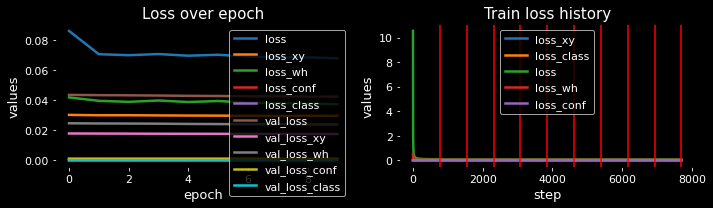

In [4]:
model.plot_history()

## Prediction

As you can observe in the below results, the model tends to have a good *true positive* (correct detection), but also makes some *false positives* (wrong detection). You can adapt the *true positive rate* and the *false negative rate* by modifying the `obj_threshold` parameter. The `nms_threshold` allows to adjust the suppression of overlapping boxes (i.e. 2 detections that overlap).

For instance, if you put it to `0.65`, you will only have *true positives* (the 2 false positives in the 4th image will be removed) but you will lose some faces (in the 2nd and 5th images) ;)

1 boxes found :
0.4283 0.1013 0.2329 0.2357 0 0.8113


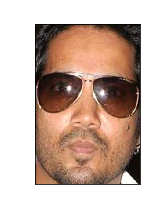

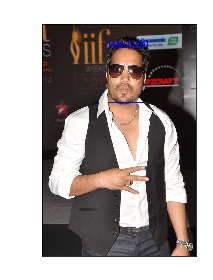

1 boxes found :
0.5234 0.3173 0.0376 0.0720 0 0.7716


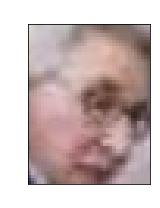

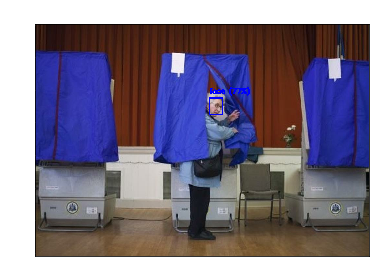

1 boxes found :
0.7719 0.3151 0.0367 0.0947 0 0.6065


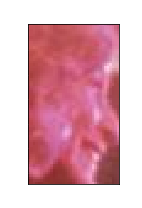

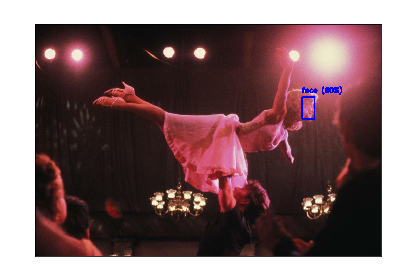

3 boxes found :
0.3900 0.2012 0.2186 0.1988 0 0.9045
0.4865 0.6067 0.0676 0.0849 0 0.6372
0.0379 0.9495 0.0647 0.0418 0 0.5804


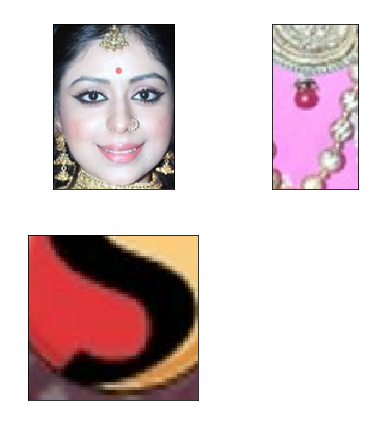

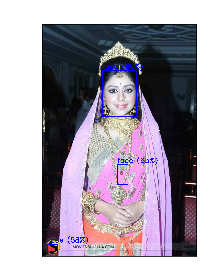

4 boxes found :
0.8587 0.0972 0.0354 0.0819 0 0.7894
0.0090 0.1463 0.0365 0.0713 0 0.5566
0.2926 0.1173 0.0501 0.0821 0 0.7730
0.6851 0.1245 0.0364 0.0704 0 0.5848


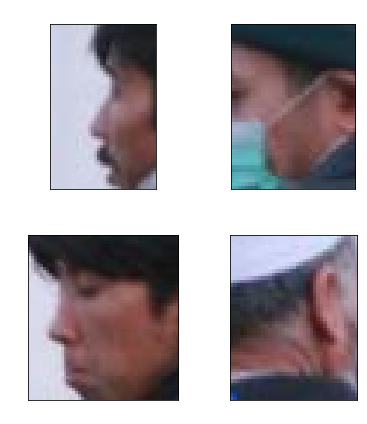

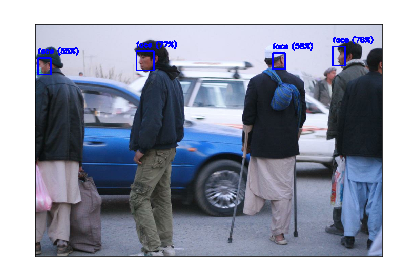

In [7]:
samples = valid.sample(5, random_state = 0)

_ = model.predict(list(samples['filename'].values), save = False, verbose = 3, obj_threshold = 0.35)

1 boxes found :
0.3941 0.3620 0.2782 0.4019 0 0.9022


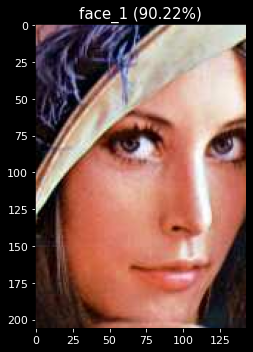

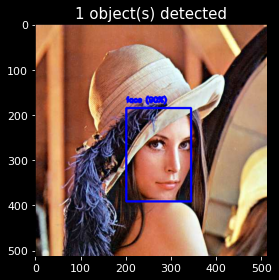

In [7]:
_ = model.predict('lena.jpg', save = False, verbose = 3, show = True, obj_threshold = 0.5)

1 boxes found :
0.5469 0.2356 0.3697 0.3780 0 0.4138


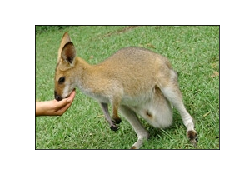

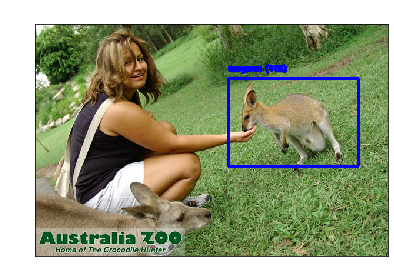

1 boxes found :
0.0417 0.0605 0.4601 0.7365 0 0.3645


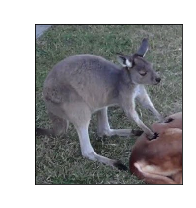

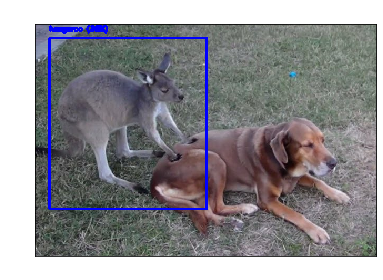

5 boxes found :
0.4869 0.0000 0.5131 0.3537 0 0.4029
0.0787 0.0697 0.3921 0.8636 0 0.4193
0.6666 0.4061 0.2733 0.4970 0 0.3647
0.0085 0.5576 0.2100 0.3464 0 0.3949
0.4288 0.4950 0.2895 0.4773 0 0.3503


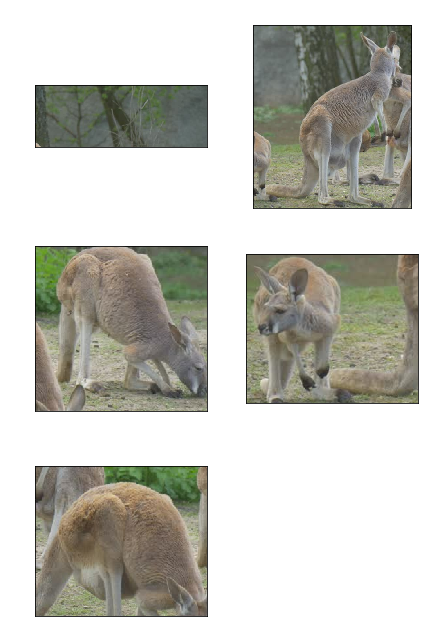

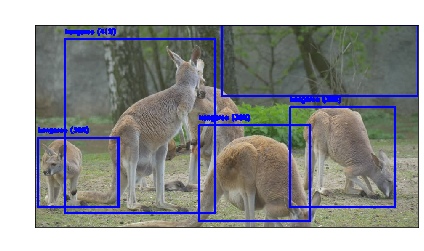

3 boxes found :
0.6673 0.0000 0.3327 0.3465 0 0.4073
0.0000 0.0000 0.4664 0.4967 0 0.3846
0.2507 0.0879 0.5041 0.8243 0 0.3836


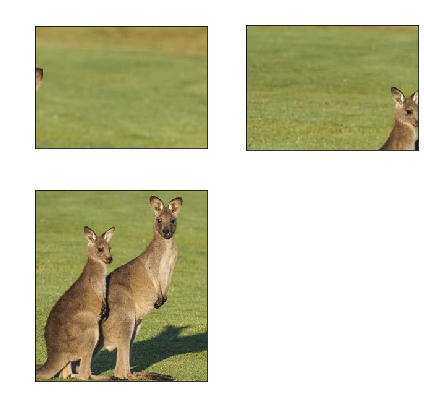

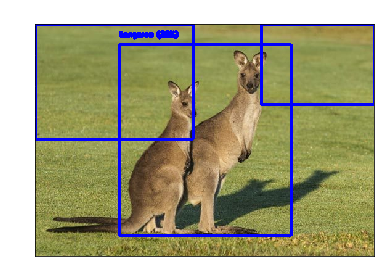

1 boxes found :
0.1098 0.1092 0.6349 0.6282 0 0.3887


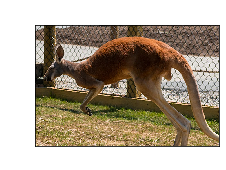

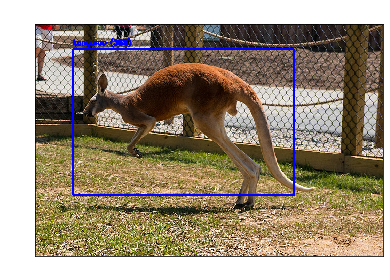

Total time : 3.383 sec
- Processing time : 0.055 sec
- Inference time : 0.107 sec
- Show time : 3.221 sec
- Saving time : 0.000 sec


In [7]:
samples = valid.sample(5, random_state = 0)

_ = model.predict(list(samples['filename'].values), save = False, verbose = 3, obj_threshold = 0.35)

### Detection on video

The `predict` function internally calls `predict_video` for `.mp4` files. The `debug` argument allows to see time for processing, inference and saving. As you can see, for a `30sec` video, it is 2 times faster than real time (`inference time`) but saving takes a lot of time especially `save_detected = True` which saves every frame with detection boxes. If you just save video (`save_video = True`) it becomes real time (around 28sec for processing + saving). 

Note : the `MoviePy` call is to copy the audio from original video to the video with detection boxes

In [ ]:
_ = model.predict(
    'my_video.mp4', save_video = True, save_frames = False, 
    overwrite = True, verbose = 3, obj_threshold = 0.3, batch_size = 64
)

## Streaming

**WARNING** : before running this cell, make sureto uncomment the `limit_gpu_memory` in the 1st cell (imports) before initializing the model. If you forgot it, I highly recommand you to restart your jupyter kernel, uncomment the line and re-load your model (you do not have to retrain it, obviously ;) just execute 1st cell (imports) and 3rd one (model instanciation) then this one).

In [ ]:
model.stream(max_time = 5, save = True, save_boxes = True, overwrite = False)

## Configure `learning-rate scheduler`

This cell allows you to play with `learning_rate scheduler`'s parameters to get the one you want !

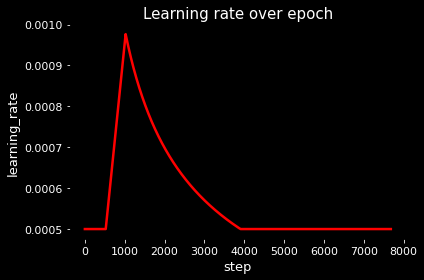

In [11]:
from custom_train_objects.optimizers.lr_schedulers import WarmupScheduler

lr = WarmupScheduler()
lr.factor = 1024.
lr.warmup_steps = 1024
lr.plot(512 * 15)

## Test dataset performances

In [9]:
config = model.get_dataset_config(is_validation = True, batch_size = 16)

ds_train = prepare_dataset(train, ** config, is_rectangular = False)

test_dataset_time(ds_train)

99it [00:36,  2.70it/s]


100 batchs in 36.651 sec sec (2.728 batch / sec)

Batch infos : 
Item 0 : shape : (16, 416, 416, 3) - type : float32- min : 0.000 - max : 1.000
Item 1 : 
 Item 0 : shape : (16, 13, 13, 5, 10) - type : float32- min : 0.000 - max : 12.714
 Item 1 : shape : (16, 1, 1, 1, 50, 4) - type : float32- min : 0.000 - max : 12.714


36.65089511871338